In [ ]:
import os
import random
import numpy as np

from collections import namedtuple
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

from keras.activations import relu
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D
from keras.layers import Dropout, concatenate
from keras.utils.vis_utils import model_to_dot
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences#
from keras.utils import to_categorical

from sklearn.metrics import classification_report

from IPython.display import SVG

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x_folds = [list() for _ in range(10)]
y_folds = [list() for _ in range(10)]

for directory in ['/content/drive/MyDrive/mr_data/txt_sentoken/pos/','/content/drive/MyDrive/mr_data/txt_sentoken/neg/'] :
    for filename in os.listdir(directory) + os.listdir(directory):
        label = directory.split("/")[-2]
        # print('label:'+ label)
        fold = int(filename.split("_")[0][2])
        # print(fold)
        with open(directory + filename,'r') as f_input:
            for line in f_input:
                x_folds[fold].append(line.strip())
                y_folds[fold].append(label)



In [ ]:
print(x_folds)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
x_all = [sentence for fold in x_folds for sentence in fold]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_all)
sequences_train = tokenizer.texts_to_sequences(x_all)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43296 unique tokens.


In [ ]:
max_input_length = max([len(x) for x in x_all])
print("Max. sequence length: ", max_input_length)


Max. sequence length:  887


In [ ]:
x_folds_padded = []
for fold in x_folds:
    tokenized_fold = tokenizer.texts_to_sequences(fold)
    x_folds_padded.append(pad_sequences(tokenized_fold, maxlen = max_input_length, padding='post', truncating='post'))


In [ ]:
le = LabelEncoder()
le.fit(y_folds[0])

y_folds_categ = []

for y_fold in y_folds:
    y_categ = le.transform(y_fold)
    y_folds_categ.append(to_categorical(y_categ, num_classes=None))

#print(y_folds_categ)

In [ ]:
def load_fasttext_embeddings():
    glove_dir = '/content/drive/MyDrive/mr_data/Glove.6B'
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

def create_embeddings_matrix(embeddings_index, vocabulary, embedding_dim=100):
    embeddings_matrix = np.random.rand(len(vocabulary)+1, embedding_dim)
    for i, word in enumerate(vocabulary):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector
    print('Matrix shape: {}'.format(embeddings_matrix.shape))
    return embeddings_matrix

def get_embeddings_layer(embeddings_matrix, name, max_len, trainable=False):
    embedding_layer = Embedding(
        input_dim=embeddings_matrix.shape[0],
        output_dim=embeddings_matrix.shape[1],
        input_length=max_len,
        weights=[embeddings_matrix],
        trainable=trainable,
        name=name)
    return embedding_layer


def get_conv_pool(x_input, max_len, sufix, n_grams=[3,4,5], feature_maps=100):
    branches = []
    for n in n_grams:
        branch = Conv1D(filters=feature_maps, kernel_size=n, activation=relu, name='Conv_'+sufix+'_'+str(n))(x_input)
        branch = MaxPooling1D(pool_size=max_len-n+1, strides=None, padding='valid', name='MaxPooling_'+sufix+'_'+str(n))(branch)
        branch = Flatten(name='Flatten_'+sufix+'_'+str(n))(branch)
        branches.append(branch)
    return branches

In [ ]:
embeddings_index = load_fasttext_embeddings()

Found 400000 word vectors.


In [ ]:
vocabulary = embeddings_index.keys()
embeddings_matrix = create_embeddings_matrix(embeddings_index, vocabulary, 100)

Matrix shape: (400001, 100)


In [ ]:
embedding_layer = get_embeddings_layer(embeddings_matrix, 'embedding_layer_static', 55, trainable=False)


In [ ]:
def load_fasttext_embeddings():
    glove_dir = '/content/drive/MyDrive/mr_data/Glove.6B'
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


def create_embeddings_matrix(embeddings_index, vocabulary, embedding_dim=100):
    embeddings_matrix = np.random.rand(len(vocabulary) + 1, embedding_dim)
    for i, word in enumerate(vocabulary):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector
    print('Matrix shape: {}'.format(embeddings_matrix.shape))
    return embeddings_matrix


def get_embeddings_layer(embeddings_matrix, name, max_len, trainable=False):
    embedding_layer = Embedding(
        input_dim=embeddings_matrix.shape[0],
        output_dim=embeddings_matrix.shape[1],
        input_length=max_len,
        weights=[embeddings_matrix],
        trainable=trainable,
        name=name)
    return embedding_layer


def get_conv_pool(x_input, max_len, suffix, n_grams=[3, 4, 5], feature_maps=100):
    branches = []
    for n in n_grams:
        branch = Conv1D(filters=feature_maps, kernel_size=n, activation=relu,
                        name='Conv_' + suffix + '_' + str(n))(x_input)
        branch = MaxPooling1D(pool_size=max_len - n + 1, strides=None, padding='valid',
                              name='MaxPooling_' + suffix + '_' + str(n))(branch)
        branch = Flatten(name='Flatten_' + suffix + '_' + str(n))(branch)
        branches.append(branch)
    return branches


def get_cnn_pre_trained_embeddings(embedding_layer, max_len, num_classes,
                                   loss='categorical_crossentropy'):
    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, max_len, 'static')
    z = concatenate(branches, axis=-1)
    z = Dropout(0.5)(z)

    # pass the concatenated vector to the prediction layer
    o = Dense(num_classes, activation='softmax', name='output')(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': loss}, optimizer='adam', metrics=['accuracy'])
    print()

    return model

In [ ]:
def get_cnn_pre_trained_embeddings(embedding_layer, max_len):
    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, max_len, 'static')
    z = concatenate(branches, axis=-1)

    # pass the concatenated vector to the predition layer
    o = Dense(1, activation='sigmoid', name='output')(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam')

    return model

In [ ]:
model = get_cnn_pre_trained_embeddings(embedding_layer, 55)


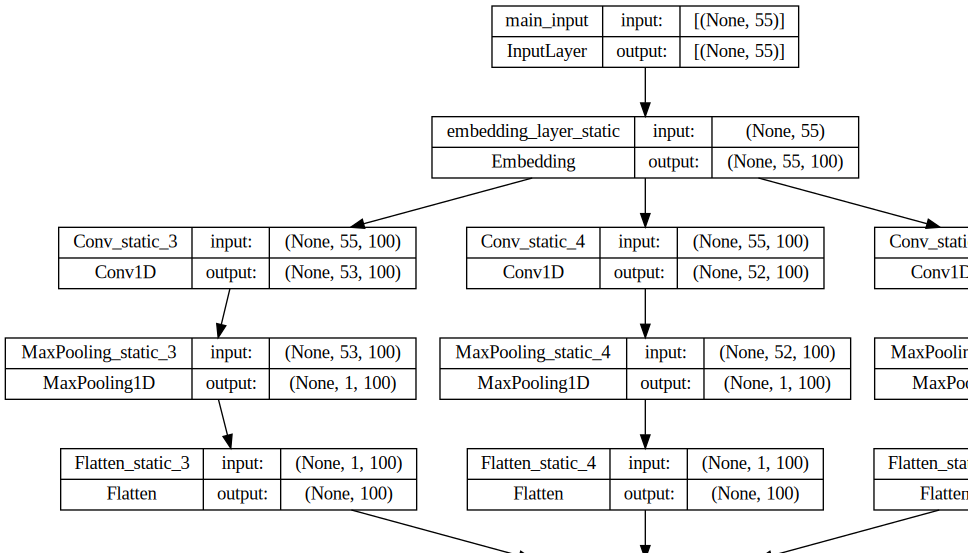

In [ ]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))


In [ ]:
# import os
# import numpy as np

# from sklearn.metrics import classification_report

# from keras.models import Model
# from keras.activations import relu
# from keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D
# from keras.layers import Dropout, concatenate

# def load_fasttext_embeddings():
#     glove_dir = '/content/drive/MyDrive/mr_data/Glove.6B'
#     embeddings_index = {}
#     f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs
#     f.close()
#     print('Loaded %s word vectors.' % len(embeddings_index))
#     return embeddings_index


# def create_embeddings_matrix(embeddings_index, vocabulary, embedding_dim=100):
#     embeddings_matrix = np.random.rand(len(vocabulary) + 1, embedding_dim)
#     for i, word in enumerate(vocabulary):
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embeddings_matrix[i] = embedding_vector
#     print('Matrix shape: {}'.format(embeddings_matrix.shape))
#     return embeddings_matrix


# def get_embeddings_layer(embeddings_matrix, name, max_len, trainable=False):
#     embedding_layer = Embedding(
#         input_dim=embeddings_matrix.shape[0],
#         output_dim=embeddings_matrix.shape[1],
#         input_length=max_len,
#         weights=[embeddings_matrix],
#         trainable=trainable,
#         name=name)
#     return embedding_layer


# def get_conv_pool(x_input, max_len, suffix, n_grams=[3, 4, 5], feature_maps=100):
#     branches = []
#     for n in n_grams:
#         branch = Conv1D(filters=feature_maps, kernel_size=n, activation=relu,
#                         name='Conv_' + suffix + '_' + str(n))(x_input)
#         branch = MaxPooling1D(pool_size=max_len - n + 1, strides=None, padding='valid',
#                               name='MaxPooling_' + suffix + '_' + str(n))(branch)
#         branch = Flatten(name='Flatten_' + suffix + '_' + str(n))(branch)
#         branches.append(branch)
#     return branches


def get_cnn_pre_trained_embeddings(embedding_layer, max_len, num_classes,
                                   loss='categorical_crossentropy'):
    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, max_len, 'static')
    z = concatenate(branches, axis=-1)
    z = Dropout(0.5)(z)

    # pass the concatenated vector to the prediction layer
    o = Dense(num_classes, activation='softmax', name='output')(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': loss}, optimizer='adam', metrics=['accuracy'])
    print()

    return model

In [ ]:
embedding_indices = load_fasttext_embeddings()

Loaded 400000 word vectors.


In [ ]:
model.fit(x_folds_padded, y_folds_categ, batch_size=50, epochs=10)

ValueError: ignored